# Import Libraries

In [1]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
from datetime import datetime
# from wordcloud import WordCloud  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import ast, json

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
sns.set_theme()
pd.set_option('display.float_format', '{:,.4f}'.format)

/kaggle/input/values-of-top-nasdaq-copanies-from-2010-to-2020/CompanyValues.csv
/kaggle/input/values-of-top-nasdaq-copanies-from-2010-to-2020/Company.csv
/kaggle/input/tweet-score/tweets_score.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company.csv


## Company Value

In [2]:
''' Format date and sort by date'''

company_value = pd.read_csv('/kaggle/input/values-of-top-nasdaq-copanies-from-2010-to-2020/CompanyValues.csv')
company_value.loc[:,"day_date"] = pd.to_datetime(company_value["day_date"])
company_value.sort_values(by=['ticker_symbol','day_date'],ascending=True, inplace = True, ignore_index=True)
company_value.set_index(['ticker_symbol','day_date'], inplace = True)
company_value.head(10)

close_value     volume  open_value  high_value  \
ticker_symbol day_date                                                     
AAPL          2010-06-01      37.2614  218455576     37.0986     37.9914   
              2010-06-02      37.7071  171594061     37.7914     37.8286   
              2010-06-03      37.5886  162341809     37.8828     37.9357   
              2010-06-04      36.5664  189045767     36.8871     37.4143   
              2010-06-07      35.8486  221253336     36.8986     37.0214   
              2010-06-08      35.6186  249904415     36.1771     36.2571   
              2010-06-09      34.7428  213040094     35.9243     35.9857   
              2010-06-10      35.7871  193507918     34.9771     35.8543   
              2010-06-11      36.2157  136154451     35.4607     36.2657   
              2010-06-14      36.3257  150469315     36.5657     37.0214   

                          low_value  
ticker_symbol day_date               
AAPL          2010-06-01    36.9943  
              2010-06-02    37.1907  
              2010-06-03    37.2014  
              2010-06-04    36.3757  
              2010-06-07    35.7928  
              2010-06-08    35.0928  
              2010-06-09    34.6414  
              2010-06-10    34.6000  
              2010-06-11    35.3386  
              2010-06-14    36.2871

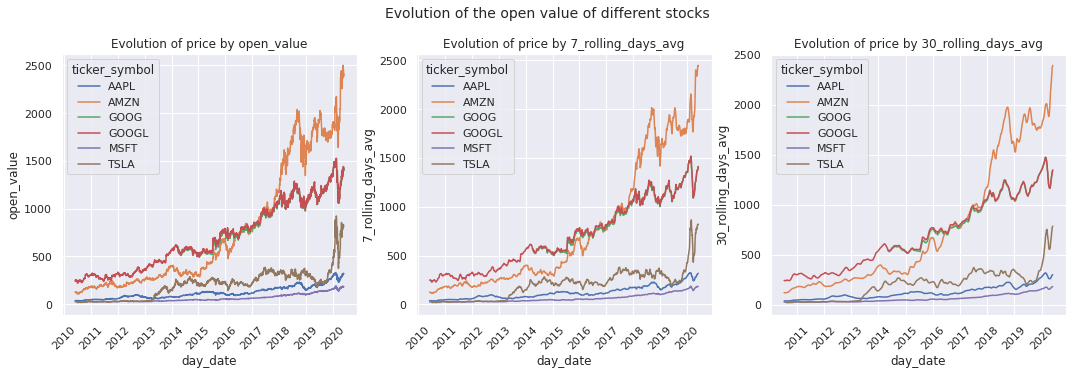

In [3]:
''' Get average of rolling values '''

company_value['7_rolling_days_avg'] = company_value.groupby(['ticker_symbol'])['open_value'].transform(lambda x: x.rolling(7).mean())
company_value['30_rolling_days_avg'] = company_value.groupby(['ticker_symbol'])['open_value'].transform(lambda x: x.rolling(30).mean())

fig, ax = plt.subplots(1,3, figsize = (18,5))
fig.suptitle("Evolution of the open value of different stocks", fontsize = 14)
fig.subplots_adjust(top=0.85)

for var, subplot in zip(['open_value', '7_rolling_days_avg', '30_rolling_days_avg'], ax.flatten()):
    ax = sns.lineplot(x="day_date", y=var, data=company_value.reset_index(),hue="ticker_symbol", ax = subplot)
    ax.set_title("Evolution of price by {}".format(var))
    ax.tick_params(axis='x', rotation=45)

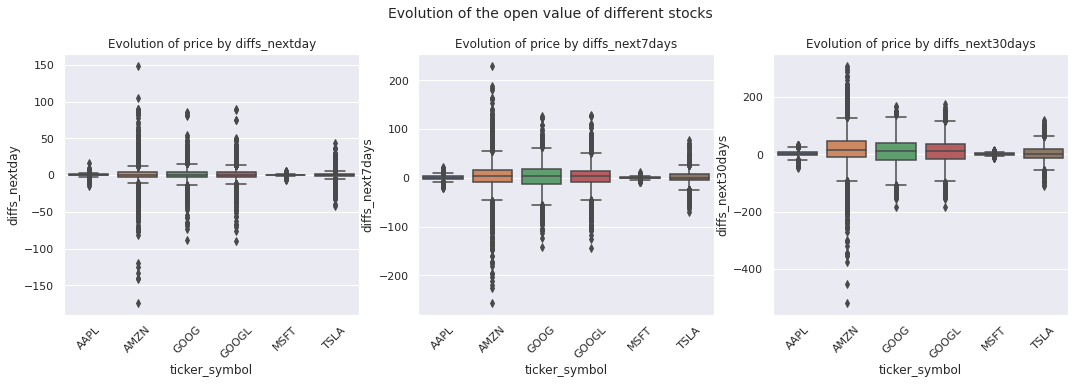

In [4]:
''' Get difference of values - Pre Covid '''


company_value['diffs_nextday'] =  company_value.groupby('ticker_symbol')['open_value'].diff()
company_value['diffs_next7days'] =  company_value.groupby('ticker_symbol')['open_value'].diff(periods = 7)
company_value['diffs_next30days'] =  company_value.groupby('ticker_symbol')['open_value'].diff(periods = 30)

fig, ax = plt.subplots(1,3, figsize = (18,5))
fig.suptitle("Evolution of the open value of different stocks", fontsize = 14)
fig.subplots_adjust(top=0.85)

for var, subplot in zip(['diffs_nextday', 'diffs_next7days', 'diffs_next30days'], ax.flatten()):
    df = company_value.reset_index()
    ax = sns.boxplot(y=var, x="ticker_symbol", data=df[df['day_date'].dt.year <2020 ], ax = subplot)
    ax.set_title("Evolution of price by {}".format(var))
    ax.tick_params(axis='x', rotation=45)

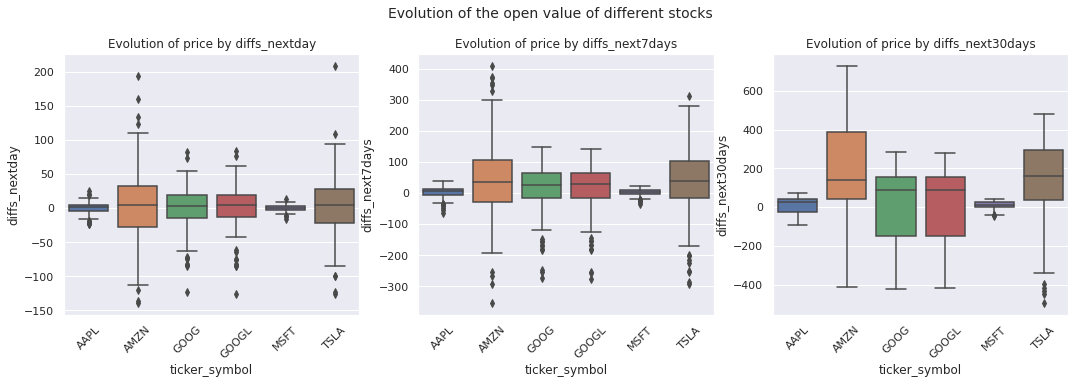

In [5]:
''' Get difference of values - Post Covid '''

fig, ax = plt.subplots(1,3, figsize = (18,5))
fig.suptitle("Evolution of the open value of different stocks", fontsize = 14)
fig.subplots_adjust(top=0.85)

for var, subplot in zip(['diffs_nextday', 'diffs_next7days', 'diffs_next30days'], ax.flatten()):
    df= company_value.reset_index()
    ax = sns.boxplot(y=var, x="ticker_symbol", data=df[df['day_date'].dt.year > 2019], ax = subplot)
    ax.set_title("Evolution of price by {}".format(var))
    ax.tick_params(axis='x', rotation=45)

In [6]:
''' Get trends '''

company_value['flag_nextday'] = np.where(company_value['diffs_nextday'].isna(),np.nan, np.where(company_value['diffs_nextday'] > 0, 1, -1))
company_value['flag_next7days'] = np.where(company_value['diffs_next7days'].isna(),np.nan,np.where(company_value['diffs_next7days'] > 0, 1, -1))
company_value['flag_next30days'] = np.where(company_value['diffs_next30days'].isna(),np.nan,np.where(company_value['diffs_next30days'] > 0, 1, -1))

company_value.head(10)

close_value     volume  open_value  high_value  \
ticker_symbol day_date                                                     
AAPL          2010-06-01      37.2614  218455576     37.0986     37.9914   
              2010-06-02      37.7071  171594061     37.7914     37.8286   
              2010-06-03      37.5886  162341809     37.8828     37.9357   
              2010-06-04      36.5664  189045767     36.8871     37.4143   
              2010-06-07      35.8486  221253336     36.8986     37.0214   
              2010-06-08      35.6186  249904415     36.1771     36.2571   
              2010-06-09      34.7428  213040094     35.9243     35.9857   
              2010-06-10      35.7871  193507918     34.9771     35.8543   
              2010-06-11      36.2157  136154451     35.4607     36.2657   
              2010-06-14      36.3257  150469315     36.5657     37.0214   

                          low_value  7_rolling_days_avg  30_rolling_days_avg  \
ticker_symbol day_date                                                         
AAPL          2010-06-01    36.9943                 NaN                  NaN   
              2010-06-02    37.1907                 NaN                  NaN   
              2010-06-03    37.2014                 NaN                  NaN   
              2010-06-04    36.3757                 NaN                  NaN   
              2010-06-07    35.7928                 NaN                  NaN   
              2010-06-08    35.0928                 NaN                  NaN   
              2010-06-09    34.6414             36.9514                  NaN   
              2010-06-10    34.6000             36.6483                  NaN   
              2010-06-11    35.3386             36.3154                  NaN   
              2010-06-14    36.2871             36.1272                  NaN   

                          diffs_nextday  diffs_next7days  diffs_next30days  \
ticker_symbol day_date                                                       
AAPL          2010-06-01            NaN              NaN               NaN   
              2010-06-02         0.6928              NaN               NaN   
              2010-06-03         0.0914              NaN               NaN   
              2010-06-04        -0.9957              NaN               NaN   
              2010-06-07         0.0115              NaN               NaN   
              2010-06-08        -0.7215              NaN               NaN   
              2010-06-09        -0.2528              NaN               NaN   
              2010-06-10        -0.9472          -2.1215               NaN   
              2010-06-11         0.4836          -2.3307               NaN   
              2010-06-14         1.1050          -1.3171               NaN   

                          flag_nextday  flag_next7days  flag_next30days  
ticker_symbol day_date                                                   
AAPL          2010-06-01           NaN             NaN              NaN  
              2010-06-02        1.0000             NaN              NaN  
              2010-06-03        1.0000             NaN              NaN  
              2010-06-04       -1.0000             NaN              NaN  
              2010-06-07        1.0000             NaN              NaN  
              2010-06-08       -1.0000             NaN              NaN  
              2010-06-09       -1.0000             NaN              NaN  
              2010-06-10       -1.0000         -1.0000              NaN  
              2010-06-11        1.0000         -1.0000              NaN  
              2010-06-14        1.0000         -1.0000              NaN

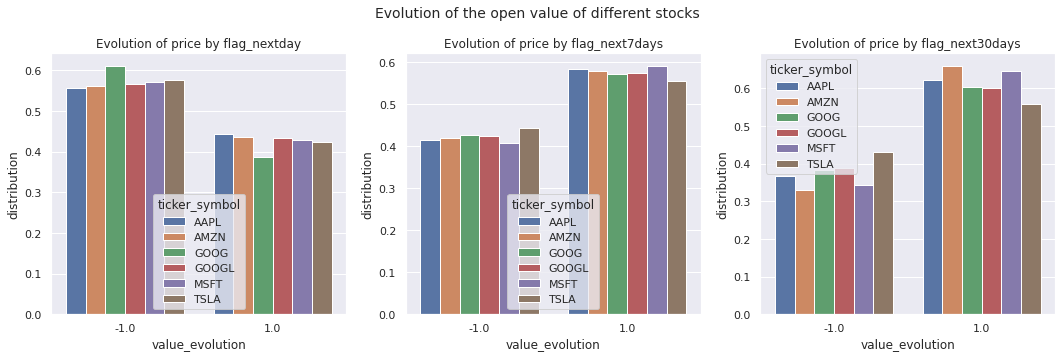

In [7]:
fig, ax = plt.subplots(1,3, figsize = (18,5))
fig.suptitle("Evolution of the open value of different stocks", fontsize = 14)
fig.subplots_adjust(top=0.85)

for var, subplot in zip(['flag_nextday', 'flag_next7days', 'flag_next30days'], ax.flatten()):
    dist = company_value.groupby("ticker_symbol")[var].apply(lambda x : x.value_counts()/len(x))
    dist = dist.rename("distribution").reset_index()
    dist = dist.rename(columns={"level_1" : "value_evolution"})
    ax = sns.barplot(data=dist,x="value_evolution",y="distribution",hue="ticker_symbol",  ax = subplot)
    ax.set_title("Evolution of price by {}".format(var))


In [8]:
''' Descriptive statistics '''

company_value.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
close_value,"17,528.0000",455.1670,469.3246,15.8000,100.3000,256.5000,735.6300,"2,497.9400"
volume,"17,528.0000","20,254,414.3543","33,227,326.7342","7,932.0000","2,075,085.5000","4,835,617.5000","27,043,580.0000","462,442,329.0000"
open_value,"17,528.0000",455.3145,469.5883,16.1400,99.8838,256.0950,735.7400,"2,500.0000"
high_value,"17,528.0000",459.7106,473.7717,16.6300,100.9275,259.6045,742.0000,"2,525.4500"
low_value,"17,528.0000",450.4667,464.7948,14.9800,98.9400,252.1774,728.9200,"2,467.2700"
7_rolling_days_avg,"17,492.0000",454.9492,468.7186,17.6206,99.8650,255.9164,735.2172,"2,447.1494"
30_rolling_days_avg,"17,354.0000",453.6551,465.6067,19.6755,100.4600,257.1539,731.1452,"2,391.7585"
diffs_nextday,"17,522.0000",0.3166,11.2526,-173.8400,-0.8700,0.0000,1.4300,209.2700
diffs_next7days,"17,486.0000",2.2248,27.9330,-353.1700,-3.4800,0.8000,7.9975,410.0000
diffs_next30days,"17,348.0000",9.2699,56.1687,-518.2500,-4.5725,3.0800,21.8725,730.5900


## Tweet

In [9]:
''' Merge and formatting and descriptive statistics'''

company_tweet = pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv')
tweet = pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv')

tweets_data = tweet.merge(company_tweet,on="tweet_id")  
tweets_data.loc[:,"post_date"] = tweets_data["post_date"].apply(datetime.fromtimestamp)
tweets_data['tweet_id'] = tweets_data['tweet_id'].astype(str)
tweets_data.set_index("post_date",inplace=True)

tweets_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,4336445,3717964,855878122071371776,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
writer,4280526,140131,App_sw_,91741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body,4336445,3326194,Join @RobinhoodApp and we'll both get a stock ...,13664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comment_num,"4,336,445.0000",NaN,NaN,NaN,0.2924,1.8858,0.0000,0.0000,0.0000,0.0000,631.0000
retweet_num,"4,336,445.0000",NaN,NaN,NaN,0.6348,6.9864,0.0000,0.0000,0.0000,0.0000,999.0000
like_num,"4,336,445.0000",NaN,NaN,NaN,2.1036,13.7174,0.0000,0.0000,0.0000,1.0000,999.0000
ticker_symbol,4336445,6,AAPL,1425013,NaN,NaN,NaN,NaN,NaN,NaN,NaN


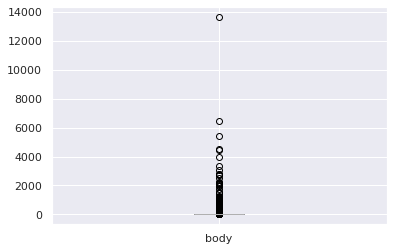

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,3326194,3326194,Join @RobinhoodApp and we'll both get a stock ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body,"3,326,194.0000",NaN,NaN,NaN,1.3037,12.0688,1.0000,1.0000,1.0000,1.0000,"13,664.0000"


,index,body
0,Join @RobinhoodApp and we'll both get a stock ...,13664
1,"THE BINARY OPTIONS COMPETITION WIN $100,000 ht...",6434
2,CityFALCON score gives top rated news for FREE...,5440
3,Join @RobinhoodApp and we'll both get a share ...,4538
4,"Stay ahead with Nasdaq 100 news, views & analy...",4470
5,CityFALCON score gives top rated news for FREE...,3973
6,"Stay ahead with Nasdaq 100 news, views & analy...",3326
7,A list of free stock picks. $TWTR $TSLA $JMBA ...,3057
8,Trends matter not only in fashion but also in ...,2828
9,Screen through high rated articles for US Tech...,2799


In [10]:
''' Merge and formatting and descriptive statistics'''
df_tweet_freq = tweets_data.body.value_counts().reset_index()

''' Boxplot tweet frequency '''
df_tweet_freq.boxplot()
plt.show()
display(df_tweet_freq.describe(include='all').T)

''' Top tweets '''
display(df_tweet_freq.head(10))

Text(0.5, 1.0, 'Percentage of Tweets by Ticker')

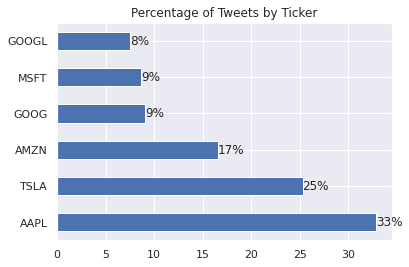

In [11]:
''' Tweets by ticker '''

g =(tweets_data.ticker_symbol.value_counts(normalize=True)*100).plot(kind="barh")
for i in g.containers:
    g.bar_label(i, fmt='%1.0f%%', label_type='edge')
g.set_title("Percentage of Tweets by Ticker")

In [12]:
''' Tweets by year '''

tweet.loc[:,"post_date"] = tweet["post_date"].apply(datetime.fromtimestamp)
tweet.reset_index().post_date.dt.year.value_counts()


# g =(tweets_data.reset_index().post_date.dt.year.value_counts(normalize=True)*100).plot(kind="barh")
# for i in g.containers:
#     g.bar_label(i, fmt='%1.0f%%', label_type='edge')
# g.set_title("Percentage of Tweets by Year")



2016    842375
2018    767126
2019    759545
2015    727896
2017    621022
Name: post_date, dtype: int64

## Sentiment Analysis

In [13]:
''' Text preprocessing and sentiment scoring '''

# sia=SentimentIntensityAnalyzer()

''' Preprocess text '''
# stop_words=stopwords.words('english')
# def remove_stopwords(txt):
#     words=word_tokenize(txt)
#     words=[w for w in words if w.isalpha()]
#     words=[w for w in words if not w in stop_words]
#     return ' '.join(words)
# tweets_data["body_pp"] = tweets_data["body"].apply(remove_stopwords)

''' Score text '''
# tweets_data["sentiment_score"]= tweets_data["body_pp"].apply(lambda z:sia.polarity_scores((z)))
# tweets_data.to_csv('tweets_score.csv') # export data for later use as processing takes time
# tweets_data.head(5)

' Score text '

In [14]:
''' Reload data and do formatting '''

df_tweet_scored = pd.read_csv('../input/tweet-score/tweets_score.csv')
df_tweet_scored['sentiment_score'] = df_tweet_scored['sentiment_score'].apply(ast.literal_eval)
df_tweet_scored['post_date'] = pd.to_datetime(df_tweet_scored['post_date']).dt.date
df_tweet_scored.head(2)

,post_date,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,body_pp,sentiment_score
0,2015-01-01,550441509175443456,VisualStockRSRC,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,made AAPL http Learn howtotrade http EXE WATT ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,2015-01-01,550441672312512512,KeralaGuy77,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,Insanity today weirdo massive selling aapl bid...,"{'neg': 0.442, 'neu': 0.558, 'pos': 0.0, 'comp..."


In [15]:
''' Expand sentiment score column '''

positive=[]
negative=[]
neutral=[]
sentiment=[]
compound=[]

THRESHOLD = 0.05

for score in df_tweet_scored["sentiment_score"]:
    positive.append(score['pos'])
    negative.append(score['neg'])
    neutral.append(score['neu'])
    compound.append(score["compound"])
    if (score['compound']>THRESHOLD):
        sentiment.append("1")
    elif (score['compound']<=THRESHOLD):
        sentiment.append("-1")
    else:
        sentiment.append("0")
        
sentiment_data=pd.DataFrame({"positive":positive,"negative":negative,"neutral":neutral,"compound":compound,"sentiment":sentiment})
df_sentiment = pd.concat([df_tweet_scored,sentiment_data],axis=1)
df_sentiment.head()

,post_date,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,body_pp,sentiment_score,positive,negative,neutral,compound,sentiment
0,2015-01-01,550441509175443456,VisualStockRSRC,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,made AAPL http Learn howtotrade http EXE WATT ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,1.0000,0.0000,-1
1,2015-01-01,550441672312512512,KeralaGuy77,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,Insanity today weirdo massive selling aapl bid...,"{'neg': 0.442, 'neu': 0.558, 'pos': 0.0, 'comp...",0.0000,0.4420,0.5580,-0.8271,-1
2,2015-01-01,550441732014223360,DozenStocks,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,S Stocks Performance HD LOW SBUX TGT DVN IBM A...,"{'neg': 0.143, 'neu': 0.857, 'pos': 0.0, 'comp...",0.0000,0.1430,0.8570,-0.4278,-1
3,2015-01-01,550442977802207232,ShowDreamCar,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,GM TSLA Volkswagen Pushes Record Recall Tally ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,1.0000,0.0000,-1
4,2015-01-01,550443807834402816,i_Know_First,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,Swing Trading Up To Return In Days http swingt...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,1.0000,0.0000,-1


In [16]:
''' Aggregate table by ticker and date to get average sentiment score '''

df_agg_sentiment= df_sentiment.groupby(['ticker_symbol','post_date'])['compound'].mean().reset_index()
df_agg_sentiment.set_index(['ticker_symbol','post_date'], inplace = True)
df_agg_sentiment.head()

compound
ticker_symbol post_date           
AAPL          2015-01-01    0.1432
              2015-01-02    0.0982
              2015-01-03    0.2219
              2015-01-04    0.2138
              2015-01-05    0.1504

In [17]:
''' Concat tweets with value by splitting by ticker to speed up computing process '''

tickers = ['AAPL', 'GOOG', 'GOOGL','MSFT', 'AMZN', 'TSLA'] 

dic_value = {}
dftemp = company_value[['open_value']]
for i in tickers:
    dic_value[i]= dftemp.loc[i]

dic_sentiment = {}
for i in tickers:
    dic_sentiment[i]= df_agg_sentiment.loc[i]

dic_valueSentiment = {}
for i in tickers:
    dic_valueSentiment[i] = dic_sentiment[i].merge(dic_value[i], how='left', left_index = True, right_index = True)


Ticker - AAPL


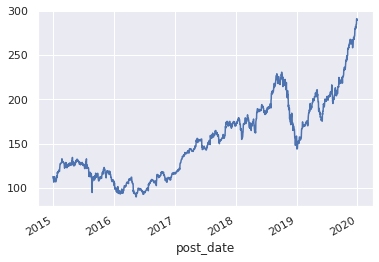

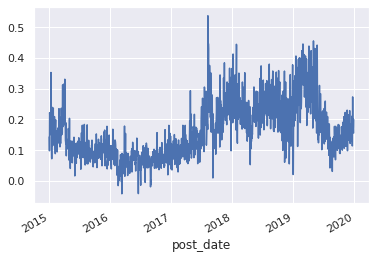

Ticker correlation : AAPL


,compound,open_value
compound,1.0000,0.5345
open_value,0.5345,1.0000


Ticker - GOOG


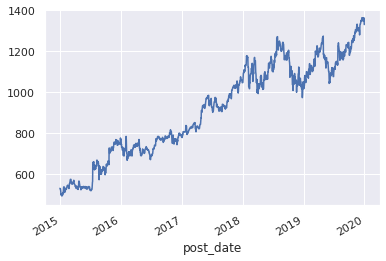

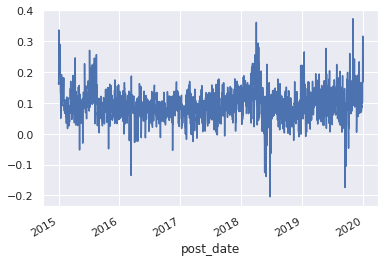

Ticker correlation : GOOG


,compound,open_value
compound,1.0000,0.0502
open_value,0.0502,1.0000


Ticker - GOOGL


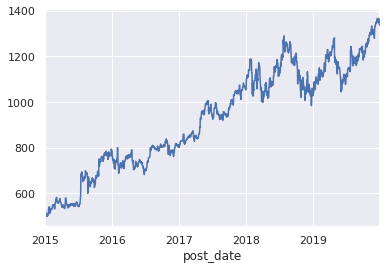

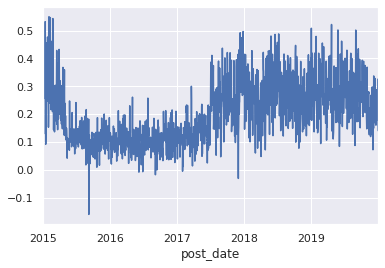

Ticker correlation : GOOGL


,compound,open_value
compound,1.0000,0.4476
open_value,0.4476,1.0000


Ticker - MSFT


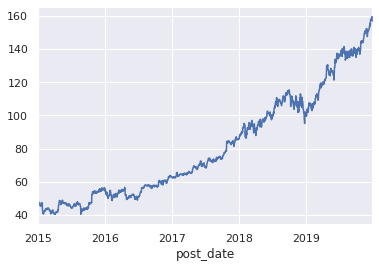

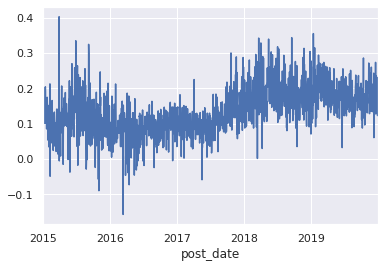

Ticker correlation : MSFT


,compound,open_value
compound,1.0000,0.5378
open_value,0.5378,1.0000


Ticker - AMZN


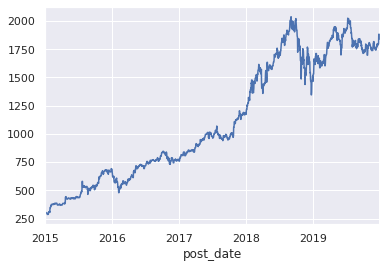

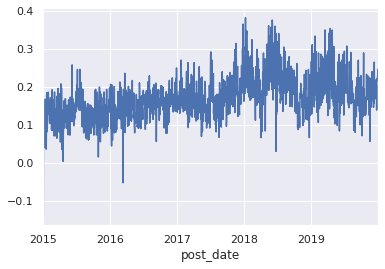

Ticker correlation : AMZN


,compound,open_value
compound,1.0000,0.4896
open_value,0.4896,1.0000


Ticker - TSLA


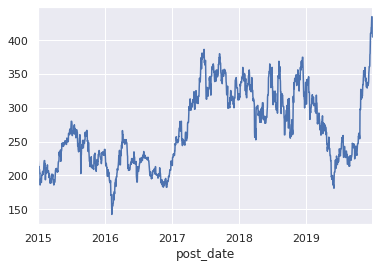

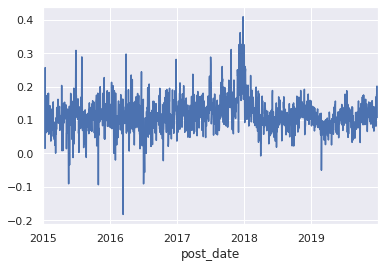

Ticker correlation : TSLA


,compound,open_value
compound,1.0000,0.2299
open_value,0.2299,1.0000


In [18]:
''' Visualize correlation between sentiment and value '''
    
for i in tickers : 
    print("Ticker - {}".format(i))
    dic_valueSentiment[i]['open_value'].plot()
    plt.show()
    dic_valueSentiment[i]['compound'].plot()
    plt.show()
    print("Ticker correlation : {}".format(i))
    display(dic_valueSentiment[i].corr())


In [19]:
''' Visualize with filtered tweet '''

FREQUENCY_THRESHOLD = 500

df_sentiment['count'] = 1

df_agg_sentiment_2= df_sentiment.groupby(['ticker_symbol','post_date']).agg({
    'compound': np.mean
    ,'count' : np.sum
    }
).reset_index()

df_agg_sentiment_2_filter = df_agg_sentiment_2[df_agg_sentiment_2['count']< FREQUENCY_THRESHOLD]
df_agg_sentiment_2_filter.set_index(['ticker_symbol','post_date'], inplace = True)
df_agg_sentiment_2_filter.head(2)

compound  count
ticker_symbol post_date                  
AAPL          2015-01-01    0.1432    299
              2015-01-03    0.2219    346

Ticker - AAPL


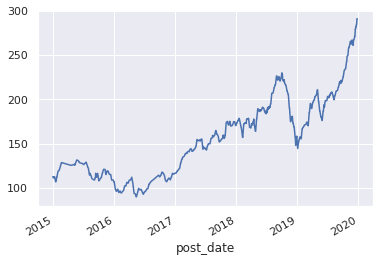

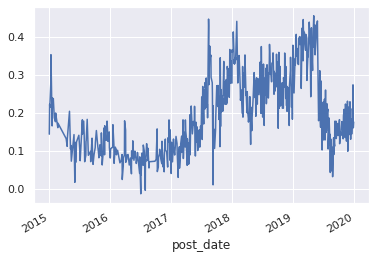

Ticker correlation : AAPL


,compound,open_value
compound,1.0000,0.4231
open_value,0.4231,1.0000


Ticker - GOOG


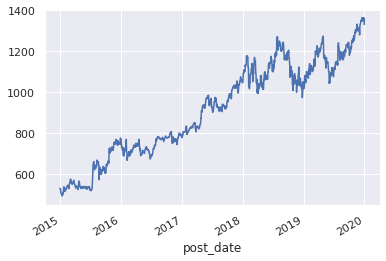

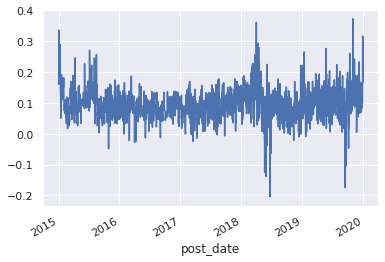

Ticker correlation : GOOG


,compound,open_value
compound,1.0000,0.0453
open_value,0.0453,1.0000


Ticker - GOOGL


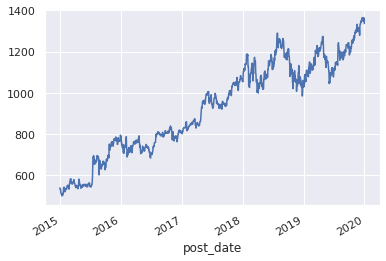

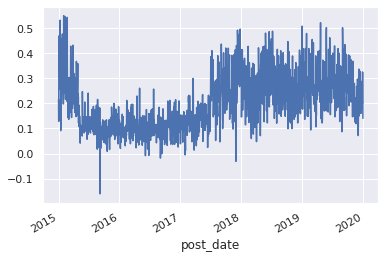

Ticker correlation : GOOGL


,compound,open_value
compound,1.0000,0.4536
open_value,0.4536,1.0000


Ticker - MSFT


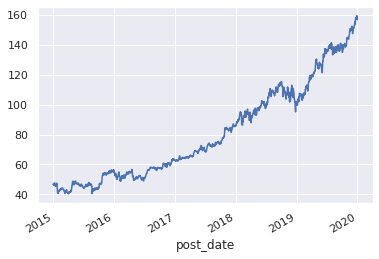

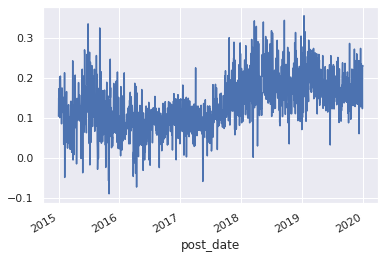

Ticker correlation : MSFT


,compound,open_value
compound,1.0000,0.5412
open_value,0.5412,1.0000


Ticker - AMZN


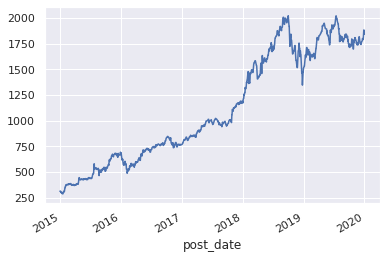

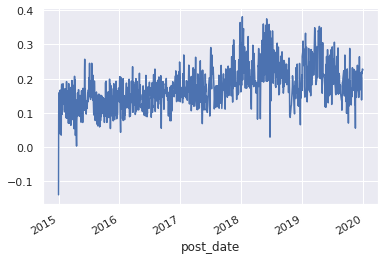

Ticker correlation : AMZN


,compound,open_value
compound,1.0000,0.5603
open_value,0.5603,1.0000


Ticker - TSLA


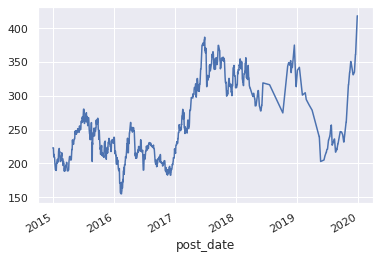

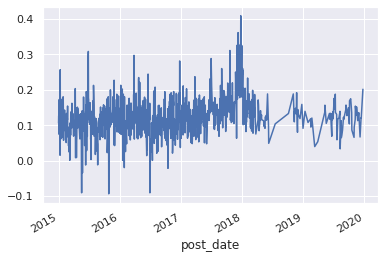

Ticker correlation : TSLA


,compound,open_value
compound,1.0000,0.3390
open_value,0.3390,1.0000


In [20]:
dic_sentiment_filtered = {}

for i in tickers:
    dic_sentiment_filtered[i]= df_agg_sentiment_2_filter.loc[i][['compound']]
    
dic_valueSentiment_filtered = {}
for i in tickers:
    dic_valueSentiment_filtered[i] = dic_sentiment_filtered[i].merge(dic_value[i], how='left', left_index = True, right_index = True)
    
for i in tickers : 
    print("Ticker - {}".format(i))
    dic_valueSentiment_filtered[i]['open_value'].plot()
    plt.show()
    dic_valueSentiment_filtered[i]['compound'].plot()
    plt.show()
    print("Ticker correlation : {}".format(i))
    display(dic_valueSentiment_filtered[i].corr())


# Tweet data year analysis

In [21]:
tweet = pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv')
tweet.head(2)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0


In [22]:
tweet.loc[:,"post_date"] = tweet["post_date"].apply(datetime.fromtimestamp)
tweet.head(2)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0


In [23]:
tweet["year"] = tweet.post_date.dt.year
tweet.head(2)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,year
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,2015
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,2015


In [24]:
tweet['year'].value_counts()

2016    842375
2018    767126
2019    759545
2015    727896
2017    621022
Name: year, dtype: int64

In [25]:
tweet["year"].max()

2019